# World Bank Home Ownership

This notebook is used to develop code to create a data dashboard for World Bank information on the poverty gap at national poverty lines. 

## Data
The data used is found at: 
https://databank.worldbank.org/data/reports.aspx?source=2&series=SI.POV.NAGP

## Gather

In [54]:
import json
import requests
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Define query function
def api_query(data_code, params):
    link = 'https://api.worldbank.org/v2/en/country/all/indicator/'
    r = requests.get(link + data_code, params=params)
    return r.json()

In [55]:
# Set up request parameters
params = {'format': 'json', 'per_page': '1000', 'date': '1990:2017'}

In [4]:
poverty = api_query('SI.POV.NAGP', params)

In [6]:
# Get results details
poverty[0]

{'page': 1,
 'pages': 7,
 'per_page': 1000,
 'total': 6864,
 'sourceid': '2',
 'lastupdated': '2019-01-30'}

There are 7 pages of results that contain 6,864 records.

In [15]:
poverty[1][0]

{'indicator': {'id': 'SI.POV.NAGP',
  'value': 'Poverty gap at national poverty lines (%)'},
 'country': {'id': '1A', 'value': 'Arab World'},
 'countryiso3code': '',
 'date': '2015',
 'value': None,
 'unit': '',
 'obs_status': '',
 'decimal': 1}

The keys I want are `country['id']`, `country['value']`, `date`, `value`.

In [29]:
def full_query(data_code, params, folder_name):
    # Complete initial query
    initial = api_query(data_code, params)
    
    # Determine number of pages for full results
    num_pages = initial[0]['pages']
    
    # Create data directory
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    for i in range(num_pages):
        # Save file
        file_name = data_code + '_pg_' + str(i + 1) + '.txt'
        file_path = os.path.join(folder_name, file_name)
        if not os.path.isfile(file_path):
            open(file_path, 'w').close()
        
        # Update params
        params['page'] = i + 1
        
        # Complete query and save
        results = api_query(data_code, params)
        with open(file_path, 'w') as file:
            json.dump(results, file)

In [56]:
full_query('SI.POV.NAGP', params, 'data')

In [57]:
def extract_data(folder_name):
    df_list = []
    
    directory = os.fsencode(folder_name)
    for file in os.listdir(directory):
        file_name = os.fsdecode(file)
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_name, file_name)
            with open(file_path) as json_file:
                data = json.load(json_file)
                for entry in data[1]:
                    df_list.append({
                        'country_id': entry['country']['id'],
                        'country_name': entry['country']['value'],
                        'year': entry['date'],
                        'value': entry['value']
                    })
    
    df = pd.DataFrame(df_list, columns=['country_id', 'country_name', 'year', 'value'])
    
    return df

In [58]:
df = extract_data('data')

In [59]:
df.head()

,country_id,country_name,year,value
0,1A,Arab World,2017,NaN
1,1A,Arab World,2016,NaN
2,1A,Arab World,2015,NaN
3,1A,Arab World,2014,NaN
4,1A,Arab World,2013,NaN


In [60]:
df.shape

(7392, 4)

In [61]:
df.country_id.unique()

array(['1A', 'S3', 'B8', 'V2', 'Z4', '4E', 'T4', 'XC', 'Z7', '7E', 'T7',
       'EU', 'F1', 'XE', 'XD', 'XF', 'ZT', 'XH', 'XI', 'XG', 'V3', 'ZJ',
       'XJ', 'T2', 'XL', 'XO', 'XM', 'XN', 'ZQ', 'XQ', 'T3', 'XP', 'XU',
       'XY', 'OE', 'S4', 'S2', 'V4', 'V1', 'S1', '8S', 'T5', 'ZG', 'ZF',
       'T6', 'XT', '1W', 'AF', 'AL', 'DZ', 'AS', 'AD', 'AO', 'AG', 'AR',
       'AM', 'AW', 'AU', 'AT', 'AZ', 'BS', 'BH', 'BD', 'BB', 'BY', 'BE',
       'BZ', 'BJ', 'BM', 'BT', 'BO', 'BA', 'BW', 'BR', 'VG', 'BN', 'BG',
       'BF', 'BI', 'CV', 'KH', 'CM', 'CA', 'KY', 'CF', 'TD', 'JG', 'CL',
       'CN', 'CO', 'KM', 'CD', 'CG', 'CR', 'CI', 'HR', 'CU', 'CW', 'CY',
       'CZ', 'DK', 'DJ', 'DM', 'DO', 'EC', 'EG', 'SV', 'GQ', 'ER', 'EE',
       'SZ', 'ET', 'FO', 'FJ', 'FI', 'FR', 'PF', 'GA', 'GM', 'GE', 'DE',
       'GH', 'GI', 'GR', 'GL', 'GD', 'GU', 'GT', 'GN', 'GW', 'GY', 'HT',
       'HN', 'HK', 'HU', 'IS', 'IN', 'ID', 'IR', 'IQ', 'IE', 'IM', 'IL',
       'IT', 'JM', 'JP', 'JO', 'KZ', 'KE', 'KI', 'K

In [62]:
df[df.isnull().sum(axis=1) > 0].shape

(7089, 4)

The majority of rows are missing data. Which countries have data?

In [63]:
no_missing = df[df.isnull().sum(axis=1) == 0]

In [64]:
no_missing.groupby('country_name')['country_name'].count().sort_values(ascending=False)

country_name
Kazakhstan                  15
Russian Federation          14
Honduras                    14
Bolivia                     14
Indonesia                   12
Uruguay                     10
Peru                         9
Montenegro                   9
Kyrgyz Republic              9
Ecuador                      9
Moldova                      9
Armenia                      7
Uganda                       7
Cambodia                     7
Costa Rica                   6
Colombia                     6
Philippines                  4
Cameroon                     4
Lao PDR                      4
Mongolia                     4
Ethiopia                     4
Sri Lanka                    4
Guinea                       4
Albania                      4
Mauritania                   3
Malaysia                     3
Mexico                       3
Lesotho                      3
Malawi                       3
India                        3
                            ..
Jordan                    

What is the total number of years available?

In [65]:
no_missing.year.nunique()

24

No countries have data for every year. 

What years have the most data?

In [66]:
no_missing.groupby('year')['year'].count().sort_values(ascending=False)

year
2012    29
2009    28
2010    27
2011    26
2007    24
2008    21
2014    20
2013    18
2002    17
2006    16
2005    16
2004    14
2003    11
2015    10
2001     6
2000     6
1999     3
1996     3
1997     2
1994     2
1998     1
1995     1
1993     1
1992     1
Name: year, dtype: int64

Looks like the best years to plot are from 2002 to 2015.

Let's do 5 year intervals.

In [75]:
df.dtypes

country_id       object
country_name     object
year             object
value           float64
dtype: object

In [83]:
select_years = ['2002', '2007', '2012']

df_select_years = no_missing[no_missing.year.isin(select_years)]
df_select_not_null = df_select_years[df_select_years.notnull().all(axis=1)]

df_select_not_null.head()

,country_id,country_name,year,value
1326,AF,Afghanistan,2007,7.9
1349,AL,Albania,2012,2.9
1359,AL,Albania,2002,5.7
1545,AM,Armenia,2012,5.6
1662,AZ,Azerbaijan,2007,2.0


Let's find countries that have at least two points.

In [85]:
df_pivot = df_select_not_null.pivot(index='country_name', columns='year', values='value').reset_index()
df_pivot.head()

year,country_name,2002,2007,2012
0,Afghanistan,NaN,7.9,NaN
1,Albania,5.7,NaN,2.9
2,Armenia,NaN,NaN,5.6
3,Azerbaijan,NaN,2.0,NaN
4,Benin,NaN,9.5,NaN


In [86]:
df_pivot.shape[0]

47

In [87]:
df_pivot.dropna(subset=['2002', '2007', '2012'], thresh=2, inplace=True)

In [88]:
df_pivot.shape[0]

17

In [89]:
select_countries = df_pivot.country_name

Now we can filter for only these countries.

In [90]:
df_final = df_select_not_null[df_select_not_null.country_name.isin(select_countries)]
df_final

,country_id,country_name,year,value
1349,AL,Albania,2012,2.9
1359,AL,Albania,2002,5.7
1937,BT,Bhutan,2012,2.6
1942,BT,Bhutan,2007,6.1
1965,BO,Bolivia,2012,20.2
1970,BO,Bolivia,2007,30.5
1975,BO,Bolivia,2002,34.9
2917,EC,Ecuador,2012,10.5
2922,EC,Ecuador,2007,15.3
3589,GN,Guinea,2012,18.4


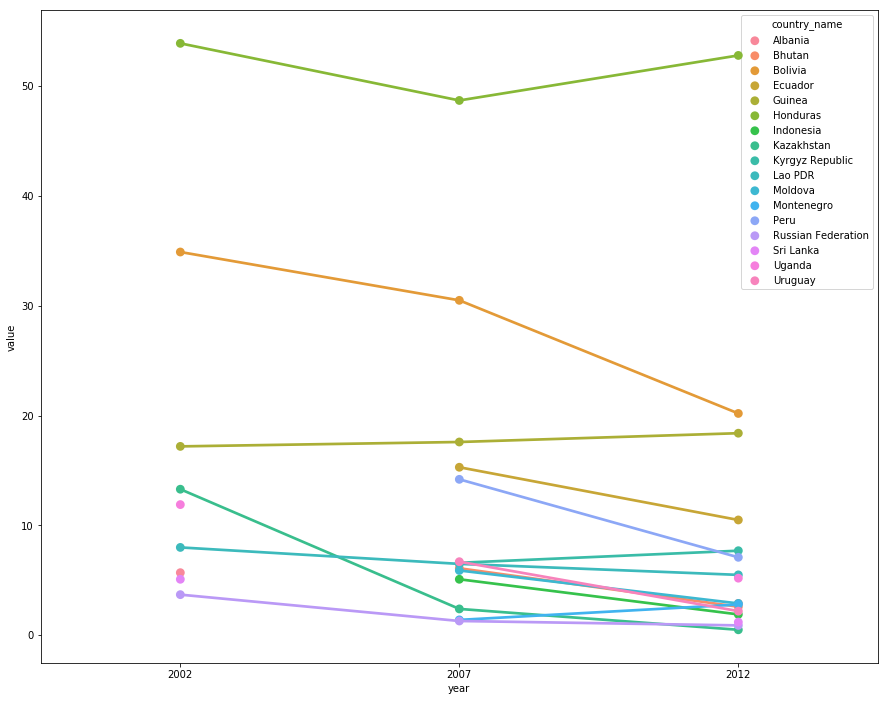

In [91]:
plt.figure(figsize=(15, 12))
sns.pointplot(x='year', y='value', hue='country_name', data=df_final);

The countries that have data for this index seem to be poorer countries. 

Is there any indicator that has a wider spread of countries that have collected data?

What about:
- Income of highest 10%: SI.DST.10TH.10
- Income of lowest 10%: SI.DST.FRST.10

In [93]:
params = {'format': 'json', 'per_page': '1000', 'date': '1990:2017'}

for data_code, file_name in zip(['SI.DST.10TH.10', 'SI.DST.FRST.10'], ['highest_10', 'lowest_10']):
    full_query(data_code, params, 'data/' + file_name)

In [94]:
df_highest = extract_data('data/highest_10')
df_highest.head()

,country_id,country_name,year,value
0,1A,Arab World,2017,NaN
1,1A,Arab World,2016,NaN
2,1A,Arab World,2015,NaN
3,1A,Arab World,2014,NaN
4,1A,Arab World,2013,NaN


In [96]:
df_h_notna = df_highest.dropna()
df_h_notna.shape

(1304, 4)

In [97]:
df_lowest = extract_data('data/lowest_10')
df_lowest.head()

,country_id,country_name,year,value
0,1A,Arab World,2017,NaN
1,1A,Arab World,2016,NaN
2,1A,Arab World,2015,NaN
3,1A,Arab World,2014,NaN
4,1A,Arab World,2013,NaN


In [101]:
df_l_notna = df_lowest.dropna()
df_l_notna.shape

(1304, 4)

Happily it would appear that the countries and years that have data for these indicators are the same.

In [103]:
(df_l_notna.drop('value', axis=1) == df_h_notna.drop('value', axis=1)).sum()

country_id      1304
country_name    1304
year            1304
dtype: int64

Yes, this is correct, all cells in all rows for both df, apart from value are equal.

What years have the most data?

In [104]:
df_l_notna.groupby('year')['year'].count().sort_values(ascending=False)

year
2010    82
2012    76
2011    75
2009    74
2005    72
2013    72
2006    72
2014    71
2008    71
2007    71
2004    68
2015    67
2003    53
2002    44
1998    36
2001    34
2000    33
2016    29
1996    29
1999    27
1992    26
1995    24
1997    22
1994    22
1993    22
1990    15
1991    14
2017     3
Name: year, dtype: int64

Looks like we have decent data from 2005 to 2015.

Let's do a quick plot of the distribution of the two dataframes.

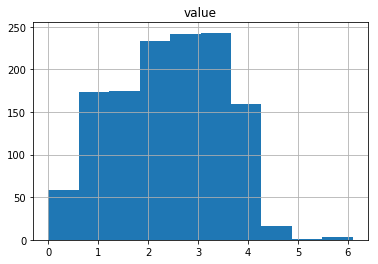

In [105]:
df_l_notna.hist();

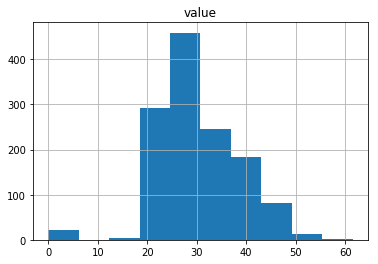

In [106]:
df_h_notna.hist();

The unit here is income share, so there is not too large of a difference between the two. 

These datasets can definitely be joined and melted. 

In [110]:
df_income_full = df_l_notna.merge(df_h_notna, on=['country_name', 'year'])
df_income_full.drop(['country_id_x', 'country_id_y'], axis=1, inplace=True)
df_income_full.rename(columns={'value_x': 'lowest_10', 'value_y': 'highest_10', 'country_name': 'country'}, inplace=True)
df_income_full.head()

,country,year,lowest_10,highest_10
0,Albania,2012,3.7,22.9
1,Albania,2008,3.7,24.5
2,Albania,2005,3.5,24.3
3,Albania,2002,3.5,25.4
4,Albania,1996,3.9,21.2


In [111]:
df_income_full['difference'] = df_income_full.highest_10 - df_income_full.lowest_10

Let's filter for the years we are looking for and select countries that have data for the majority of the years. 

In [114]:
select_years = [str(x) for x in range(2005, 2016)]
df_income_years = df_income_full[df_income_full.year.isin(select_years)]

In [125]:
df_income_pivot = df_income_years.pivot(index='country', columns='year', values='lowest_10').reset_index()
df_income_pivot.dropna(subset=select_years, thresh=3, inplace=True)
select_countries = df_income_pivot.country
print(len(select_countries))
select_countries

83


0                     Albania
3                   Argentina
4                     Armenia
6                     Austria
9                     Belarus
10                    Belgium
13                    Bolivia
14     Bosnia and Herzegovina
16                     Brazil
17                   Bulgaria
22                     Canada
25                      Chile
27                   Colombia
31                 Costa Rica
33                    Croatia
34                     Cyprus
35             Czech Republic
36                    Denmark
38         Dominican Republic
39                    Ecuador
40           Egypt, Arab Rep.
41                El Salvador
42                    Estonia
46                    Finland
47                     France
50                    Georgia
51                    Germany
53                     Greece
58                   Honduras
59                    Hungary
                ...          
103                 Nicaragua
104                     Niger
106       

Interesting, the United States, Canada, and Australia are not in this list. Let's see what data they have.

In [116]:
df_income_full.query('country == "Australia"')

,country,year,lowest_10,highest_10,difference
51,Australia,2010,2.8,26.4,23.6
52,Australia,2008,2.8,27.4,24.6
53,Australia,2003,2.7,25.1,22.4
54,Australia,2001,2.7,25.1,22.4
55,Australia,1995,2.9,24.6,21.7


In [117]:
df_income_full.query('country == "Canada"')

,country,year,lowest_10,highest_10,difference
199,Canada,2013,2.4,25.3,22.9
200,Canada,2010,2.7,25.7,23.0
201,Canada,2007,2.7,26.0,23.3
202,Canada,2004,2.6,25.6,23.0
203,Canada,2000,2.7,25.5,22.8
204,Canada,1998,2.7,25.3,22.6
205,Canada,1997,2.8,23.8,21.0
206,Canada,1994,2.9,23.6,20.7
207,Canada,1991,2.9,23.6,20.7


In [119]:
df_income_full.query('country == "United States"')

,country,year,lowest_10,highest_10,difference
1238,United States,2016,1.7,30.6,28.9
1239,United States,2013,1.7,30.1,28.4
1240,United States,2010,1.7,29.4,27.7
1241,United States,2007,1.7,30.5,28.8
1242,United States,2004,1.7,30.2,28.5
1243,United States,2000,1.9,30.4,28.5
1244,United States,1997,1.8,30.5,28.7
1245,United States,1994,1.8,29.7,27.9
1246,United States,1991,1.9,27.6,25.7


Perhaps less surprisingly, the United States and Canada have data for most of the same years since 2000. Australia has very different years. All have below the threshold of 7 that was used. Let's update the threshold to 3.

It would be good to compare the countries with the highest difference to the countries with the lowest difference.

In [126]:
in_selected_countries = df_income_full.country.isin(select_countries)
df_country_diffs = df_income_full[in_selected_countries].groupby('country')['difference']\
.mean().reset_index().sort_values(by='difference')
df_country_diffs

,country,difference
31,Indonesia,1.252174
65,Slovenia,17.069231
64,Slovak Republic,18.284615
69,Sweden,18.338462
17,Denmark,18.423077
16,Czech Republic,18.671429
55,Norway,18.707692
23,Finland,18.853846
76,Ukraine,18.936842
4,Belarus,19.231579


Let's look at three different groupings - the highest and largest 10 (which can change over time), and the countries in the [G10](https://en.wikipedia.org/wiki/Group_of_Ten_(economics).

In [129]:
smallest_10 = df_country_diffs.head(10)['country'][1:]
largest_10 = df_country_diffs.tail(10)['country']
g10 = ['Belgium', 'Canada', 'France', 'Germany', 'Italy',
       'Japan', 'Netherlands', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']

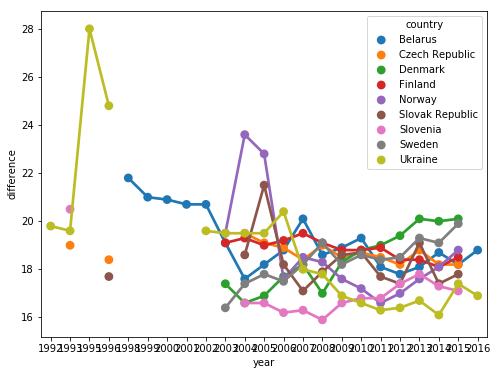

In [130]:
in_smallest_10 = df_income_full.country.isin(smallest_10)

plt.figure(figsize=(8, 6))
sns.pointplot(x='year', y='difference', hue='country', data=df_income_full[in_smallest_10]);